In [110]:
import numpy as np
import pandas as pd
import librosa
import scipy.signal as sg
import matplotlib.pyplot as plt

def _zero_pad_shift(x: np.ndarray, k: int) -> np.ndarray:
    # time-shift with zero padding (preserve length)
    y = np.zeros_like(x)
    if k >= 0:
        # delay: move right by k
        if k < len(x):
            y[k:] = x[:len(x)-k]
    else:
        # advance: move left by |k|
        k = -k
        if k < len(x):
            y[:len(x)-k] = x[k:]
    return y

def _circ_shift(x: np.ndarray, k: int) -> np.ndarray:
    # time-shift with circular wrap (preserve length, no padding)
    if len(x) == 0 or k == 0:
        return x.copy()
    k = k % len(x)
    return np.concatenate([x[-k:], x[:-k]]) if k else x.copy()

def _freq_shift_hilbert(x: np.ndarray, sr: int, df_hz: float) -> np.ndarray:
    # frequency shift via analytic signal; avoids image/mirroring artifacts
    if df_hz == 0:
        return x.copy()
    t = np.arange(len(x)) / sr
    z = sg.hilbert(x)  # analytic signal
    return np.real(z * np.exp(2j * np.pi * df_hz * t))

def _centered_indices(center_idx: int, half_len: int, total_len: int) -> np.ndarray:
    # build indices [center-half_len, center+half_len) with wraparound
    start = center_idx - half_len
    idx = (start + np.arange(2 * half_len)) % total_len
    return idx

def crop_bandpass_shift(
    audio, sr, t_min, t_max, f_min, f_max,
    time_shifts=(-0.25, 0.0, 0.25),
    freq_shifts=(-400, 0, 400),
    filt_order=6,
    target_seconds=5.0,
    pad=True
):
    # compute initial annotated segment bounds
    start = max(0, int(round(t_min * sr)))
    end = min(len(audio), int(round(t_max * sr)))
    segment = audio[start:end].astype(float, copy=False)

    target_samples = int(round(target_seconds * sr))

    if pad:
        # original behavior: pad or trim to target length
        current_len = end - start
        to_pad = target_samples - current_len
        if to_pad > 0:
            # split padding as evenly as possible
            left_pad = to_pad // 2
            right_pad = to_pad - left_pad
            segment = np.pad(segment, (left_pad, right_pad), mode="constant")
        elif to_pad < 0:
            # trim evenly from both ends
            trim = -to_pad
            left_trim = trim // 2
            right_trim = trim - left_trim
            segment = segment[left_trim: len(segment) - right_trim]
    else:
        # no padding: take a centered window of target_samples using wraparound
        if len(audio) == 0:
            return []
        center_time = 0.5 * (t_min + t_max)
        center_idx = int(round(center_time * sr))
        half_len = target_samples // 2
        # ensure even target length for symmetric crop; if odd, bias right by one
        if target_samples % 2 == 0:
            idx = _centered_indices(center_idx, half_len, len(audio))
        else:
            idx = _centered_indices(center_idx, half_len + 1, len(audio))[:-1]
        segment = audio[idx].astype(float, copy=False)

    # bandpass filter
    sos = sg.butter(filt_order, [f_min, f_max], btype='bandpass', fs=sr, output='sos')
    filtered = sg.sosfiltfilt(sos, segment)

    # choose time-shift mode based on padding option
    shift_fn = _zero_pad_shift if pad else _circ_shift

    # build a 2d list [freq_index][time_index]
    grid = []
    for df in freq_shifts:       # low→high
        row = []
        for dt in time_shifts:   # left→right
            k = int(round(dt * sr))
            t_shifted = shift_fn(filtered, k)
            x = _freq_shift_hilbert(t_shifted, sr, df)
            row.append((x, f"dt={dt:+.2f}s, df={df:+.0f}Hz, pad={pad}"))
        grid.append(row)

    return grid  # 2d list of (signal, label)

def plot_spectrogram_grid(
    grid, sr, nperseg=512, noverlap=384, cmap="magma", vmin_db=-90, vmax_db=-20
):
    nrows = len(grid)
    ncols = len(grid[0])
    fig, axes = plt.subplots(nrows, ncols, figsize=(3.6*ncols, 3.0*nrows), squeeze=False)

    for r in range(nrows):
        for c in range(ncols):
            # invert row index so high freqs are at top
            x, title = grid[nrows-1-r][c]
            f, t, Sxx = sg.spectrogram(
                x, fs=sr, nperseg=nperseg, noverlap=noverlap,
                scaling='spectrum', mode='magnitude'
            )
            Sxx_db = 20*np.log10(np.maximum(Sxx, 1e-12))
            ax = axes[r][c]
            im = ax.pcolormesh(
                t, f, Sxx_db, shading='auto', cmap=cmap,
                vmin=vmin_db, vmax=vmax_db  # <-- corrected here
            )
            ax.set_title(title, fontsize=9)
            ax.set_ylabel("Hz")
            ax.set_xlabel("s")

    return fig


In [135]:
annotations_path = '../../data/annotations/train_tp.csv'
audio_source_path = '../../data/audio/source/'
annotations = pd.read_csv(annotations_path)
# annotations = annotations[(annotations.species_id == 18)]
annotations[:3]


,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max
0,003bec244,14,1,44.5440,2531.25,45.1307,5531.25
1,006ab765f,23,1,39.9615,7235.16,46.0452,11283.40
2,007f87ba2,12,1,39.1360,562.50,42.2720,3281.25


In [136]:
row = annotations.sample(1)
row


,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max
530,6b9e3f7c6,21,1,7.6373,3281.25,8.7307,4125.0


In [137]:
# load source audio and get annotation
audio_path = audio_source_path + row.recording_id + '.flac'
audio_path = audio_source_path + row.recording_id + '.flac'
t_min = row.t_min.iloc[0]
t_max = row.t_max.iloc[0]
f_min = row.f_min.iloc[0]
f_max = row.f_max.iloc[0]

audio, sr = librosa.load(str(audio_path.values[0]), sr=32000, mono=True)


In [138]:
versions = crop_bandpass_shift(
    audio = audio,
    sr = sr,
    t_min = t_min,
    t_max = t_max,
    f_min = f_min, 
    f_max = f_max,
    time_shifts=np.linspace(-1, 1, 6),   # seconds
    freq_shifts=np.linspace(0, 8000, 6), # Hz
    pad=False
)

versions2 = crop_bandpass_shift(
    audio = audio,
    sr = sr,
    t_min = t_min,
    t_max = t_max,
    f_min = f_min, 
    f_max = f_max,
    time_shifts=np.linspace(-1, 1, 6),   # seconds
    freq_shifts=np.linspace(0, 8000, 6), # Hz
    pad=True
)



In [139]:
versions = [i[:3] + j[-3:] for i, j in zip(versions, versions2)]


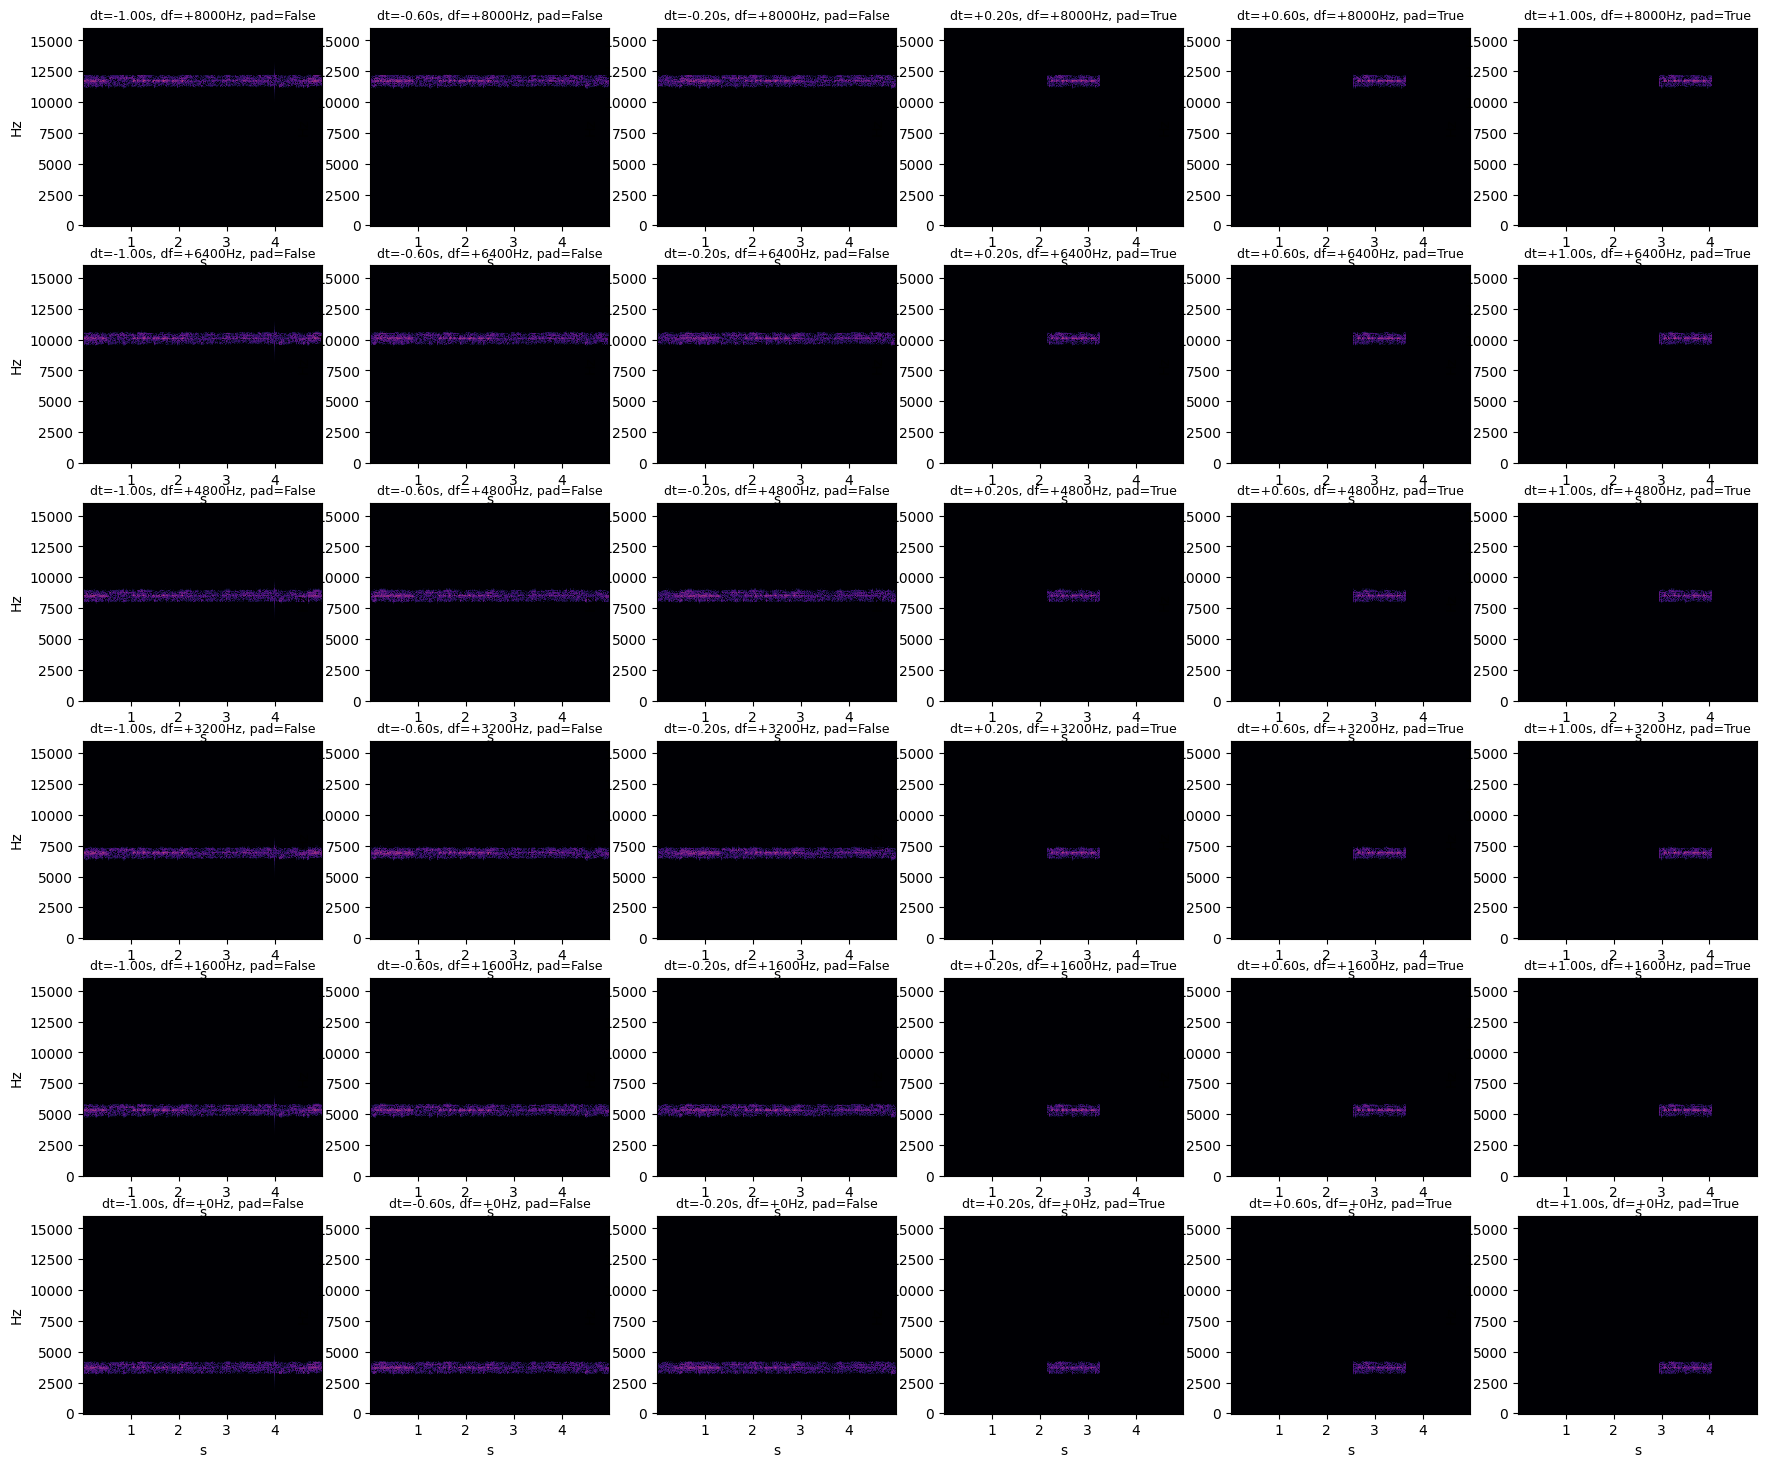

In [140]:
fig = plot_spectrogram_grid(versions, sr)
plt.show()


In [141]:
from bacpipe.generate_embeddings import Embedder
embedder = Embedder('perch_bird', testing=False)


In [142]:
def grid_to_array(grid, target_len=None, pad_value=0.0):
    """
    convert 2d grid of (signal, label) into
    (n_versions, n_audio_samples) array and a parallel list of labels

    Parameters
    ----------
    grid : list[list[tuple]]
        2d grid from crop_bandpass_shift, shape [n_freq][n_time]
    target_len : int or None
        desired output length. if None, use max length in grid
    pad_value : float
        value for padding shorter signals

    Returns
    -------
    arr : np.ndarray, shape (n_versions, target_len)
    labels : list[str]
    """
    flat_signals = []
    flat_labels = []

    for row in grid:
        for sig, lab in row:
            flat_signals.append(sig)
            flat_labels.append(lab)

    if target_len is None:
        target_len = max(len(s) for s in flat_signals)

    arr = np.full((len(flat_signals), target_len), pad_value, dtype=float)
    for i, sig in enumerate(flat_signals):
        L = min(len(sig), target_len)
        arr[i, :L] = sig[:L]

    return arr, flat_labels

versions, labels = grid_to_array(versions)


In [143]:
embeddings = embedder.model.batch_inference(versions)


 processing batches:   0%|          | 0/36 [00:00<?, ?it/s]2025-08-21 16:16:03.053031: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator jax2tf_infer_fn_/assert_equal_1/Assert/AssertGuard/Assert


In [144]:
embeddings.shape


(36, 1280)

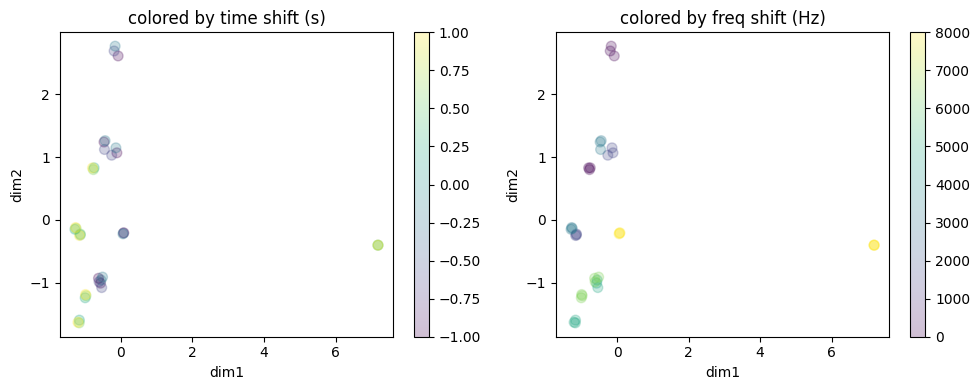

In [145]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import re

def parse_labels(labels):
    """
    parse dt and df from labels like 'dt=-0.25s, df=+300Hz'
    returns two np.ndarrays: time_shifts, freq_shifts
    """
    dt_vals, df_vals = [], []
    for lab in labels:
        m = re.findall(r"dt=([+-]?[0-9.]+)s, df=([+-]?[0-9.]+)Hz", lab)
        if m:
            dt, df = m[0]
            dt_vals.append(float(dt))
            df_vals.append(float(df))
        else:
            dt_vals.append(np.nan)
            df_vals.append(np.nan)
    return np.array(dt_vals), np.array(df_vals)

def reduce_and_plot(embeddings, labels, method="pca"):
    """
    reduce embeddings to 2d and plot scatter colored by dt/df
    """
    if method == "pca":
        reducer = PCA(n_components=2)
        coords = reducer.fit_transform(embeddings)
    else:
        raise ValueError("method must be 'pca' (you can plug in UMAP/TSNE here)")

    dt, df = parse_labels(labels)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    sc1 = axes[0].scatter(coords[:,0], coords[:,1], alpha=0.25, c=dt, cmap="viridis", s=50)
    axes[0].set_title("colored by time shift (s)")
    plt.colorbar(sc1, ax=axes[0])

    sc2 = axes[1].scatter(coords[:,0], coords[:,1], alpha=0.25, c=df, cmap="viridis", s=50)
    axes[1].set_title("colored by freq shift (Hz)")
    plt.colorbar(sc2, ax=axes[1])

    for ax in axes:
        ax.set_xlabel("dim1")
        ax.set_ylabel("dim2")
    fig.tight_layout()
    return fig, coords

# arr, labels = grid_to_array(grid)
# embeddings = some_model(arr)  # shape (n_versions, d_embed)
fig, coords = reduce_and_plot(embeddings, labels, method="pca")
plt.show()


In [146]:
# import numpy as np
# import matplotlib.pyplot as plt
# from collections import defaultdict

# def plot_score_distribution(
#     scores,
#     labels,
#     query_idx=None,
#     tol=None,
#     bins="auto",
#     group_atol=1e-6,
#     histtype="step",          # outlines show even skinny piles
#     alpha=0.9
# ):
#     # parse labels
#     _, df = parse_labels(labels)

#     # filter to finite
#     finite = np.isfinite(scores) & np.isfinite(df)
#     s_all = np.asarray(scores)[finite]
#     d_all = np.asarray(df)[finite]
#     if s_all.size == 0:
#         raise ValueError("no finite scores to plot")

#     # collect groups using isclose to avoid float equality issues
#     uniq = np.unique(d_all)
#     groups = {}
#     used = np.zeros_like(d_all, dtype=bool)
#     for val in uniq:
#         mask = np.isclose(d_all, val, atol=group_atol)
#         if np.any(mask):
#             groups[val] = s_all[mask]
#             used |= mask

#     # choose colors
#     cmap = plt.get_cmap("viridis")
#     vals_sorted = np.array(sorted(groups.keys()))
#     colors = {v: cmap(i / max(1, len(vals_sorted) - 1)) for i, v in enumerate(vals_sorted)}

#     # determine bins based on all scores if bins="auto"
#     if isinstance(bins, str) and bins == "auto":
#         # use freedman–diaconis for robustness, fall back to sqrt
#         q25, q75 = np.percentile(s_all, [25, 75])
#         iqr = max(q75 - q25, 1e-12)
#         bw = 2 * iqr * (s_all.size ** (-1/3))
#         if bw > 0:
#             nb = int(np.clip(np.ceil((s_all.max() - s_all.min()) / bw), 5, 80))
#         else:
#             nb = min(20, max(5, int(np.sqrt(s_all.size))))
#         bins = nb

#     plt.figure(figsize=(8, 5))
#     for v in vals_sorted:
#         s = groups[v]
#         if s.size == 0:
#             continue
#         plt.hist(
#             s, bins=bins, histtype=histtype, linewidth=1.8,
#             color=colors[v], alpha=alpha, label=f"df={v:+.0f} Hz"
#         )

#     # add query marker and optional band window
#     if query_idx is not None:
#         s_q = scores[query_idx]
#         plt.axvline(s_q, color="k", linestyle="--", linewidth=1.5, label="query score")

#         if tol is None:
#             # default tolerance = 2× pooled within-class std of scores
#             stds = []
#             for v in vals_sorted:
#                 arr = groups[v]
#                 if arr.size > 1:
#                     stds.append(arr.std(ddof=1))
#             tol = 2.0 * (np.mean(stds) if stds else 0.0)

#         if tol and tol > 0:
#             plt.axvspan(s_q - tol, s_q + tol, color="gray", alpha=0.15, label=f"±tol={tol:.3f}")

#     # set x-lims from data with small margins
#     xmin, xmax = s_all.min(), s_all.max()
#     pad = 0.05 * max(1e-6, xmax - xmin)
#     plt.xlim(xmin - pad, xmax + pad)

#     plt.xlabel("projection score (along learned frequency axis)")
#     plt.ylabel("count")
#     plt.title("score distribution by frequency shift")
#     plt.legend(frameon=False, ncol=2)
#     plt.tight_layout()
#     return plt.gca()

# # --- example usage ---------------------------------------------------------
# # E: (n_versions, d_embed), labels: list[str] like 'dt=..., df=...'
# v = learn_freq_axis_ridge(embeddings, labels, alpha=1e-2)
# scores = scores_from_axis(embeddings, v)
# tol = 2.0 * pooled_within_df_std(scores, labels)  # e.g., 2× within-band std
# ax = plot_score_distribution(scores, labels, query_idx=0, tol=tol, bins=24)
# plt.show()
